# LSTM Training
This notebook can be used to train an LSTM for text classification and generate predictions for the kaggle competition found [here](https://www.kaggle.com/c/quora-insincere-questions-classification). 

The notebook utilizes Keras and GloVe for preprocessing using word embeddings. Then, Keras with Tensorflow backend is used for training a deep LSTM. Feel free to fork!

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Embedding, CuDNNLSTM
from keras.layers import Bidirectional, GlobalMaxPool1D, Dropout
from keras.models import Model

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# Load in training and testing data
train_df = pd.read_csv('../input/train.csv')
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


# 1. EDA
The following code will perform basic EDA to gain an understanding of the dataset and perhaps inspire the design of the neural network.

Note: Section 1 is not required for the rest of the notebook and may be skipped if desired. 

## 1.1 Sentiment Analysis
This subsection analyzes each question using the NLTK sentiment analyzer. The goal is to determine whether the sincere and insincere questions have a significant difference in sentiment. 

Note: The sentiment analyis takes about 3 minutes to run on my machine. Tips are welcome on how to increase the speed of this operation!

In [22]:
# Sentiment analysis requires the nltk package
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer and define the sentiment extraction function
sid = SentimentIntensityAnalyzer()
def extract_sentiment(text):
    scores = sid.polarity_scores(text)
    return scores['compound']

train_df['sent'] = train_df['question_text'].apply(lambda x: extract_sentiment(x))

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [23]:
print('The average sentiment score for sincere questions is {:0.4f}'.\
          format(np.mean(train_df[train_df['target']==0]['sent'])))
print('The average sentiment score for insincere questions is {:0.4f}'. \
          format(np.mean(train_df[train_df['target']==1]['sent'])))

The average sentiment score for sincere questions is 0.0835
The average sentiment score for insincere questions is -0.0999


From the density plot below, we can see that a large number of questions are classified as exactly neutral, with a sentiment score of 0.0. It would appear that there is no strong significant difference in sentiment between sincere and insincere questions

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Density')

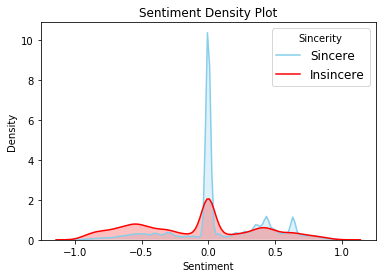

In [24]:
sent_sinc = train_df[train_df['target']==0]['sent'].values
sent_insinc = train_df[train_df['target']==1]['sent'].values

sns.kdeplot(sent_sinc, shade=1, color="skyblue", label="Sincere")
sns.kdeplot(sent_insinc, shade=1, color="red", label="Insincere")

# Plot formatting
plt.legend(prop={'size': 12}, title = 'Sincerity')
plt.title('Sentiment Density Plot')
plt.xlabel('Sentiment')
plt.ylabel('Density')

## 1.2 Word Count
This code will analyze word count characteristics of the dataset and determine whether there is a distinction in word count between the sincere and insincere questions. 

In [25]:
train_df['word_count'] = train_df['question_text'].apply(lambda x: len(x.split()))

In [26]:
print('The average word length of sincere questions in the training set is {0:.1f}.'\
          .format(np.mean(train_df[train_df['target']==0]['word_count'])))
print('The average word length of insincere questions in the training set is {0:.1f}.' \
          .format(np.mean(train_df[train_df['target']==1]['word_count'])))
print('The maximum word length for a question in the training set is {0:.0f}.'\
          .format(np.max(train_df['word_count'])))

The average word length of sincere questions in the training set is 12.5.
The average word length of insincere questions in the training set is 17.3.
The maximum word length for a question in the training set is 134.


From the plot below, we can see that the word count distribution for sincere questions has a much sharper peak. It appears that insincere questions tend to be a bit longer than sincere questions. 

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Density')

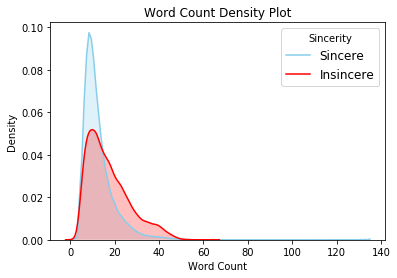

In [27]:
wc_sinc = train_df[train_df['target']==0]['word_count'].values
wc_insinc = train_df[train_df['target']==1]['word_count'].values

sns.kdeplot(wc_sinc, shade=1, color="skyblue", label="Sincere")
sns.kdeplot(wc_insinc, shade=1, color="red", label="Insincere")

# Plot formatting
plt.legend(prop={'size': 12}, title = 'Sincerity')
plt.title('Word Count Density Plot')
plt.xlabel('Word Count')
plt.ylabel('Density')

## 1.3 Word Cloud
Because word clouds look cool.

The word clouds do present some interesting information. Specifically, the insincere questions have a much higher proportion of words relating to identities and politics, such as 'Muslim', 'Trump', 'Men', 'Women', 'Liberal', 'American', etc. Conversely, the sincere questions have more constructive words that indicate the user is trying to solve a problem: 'Will', 'Good', 'Use', 'Think', etc.

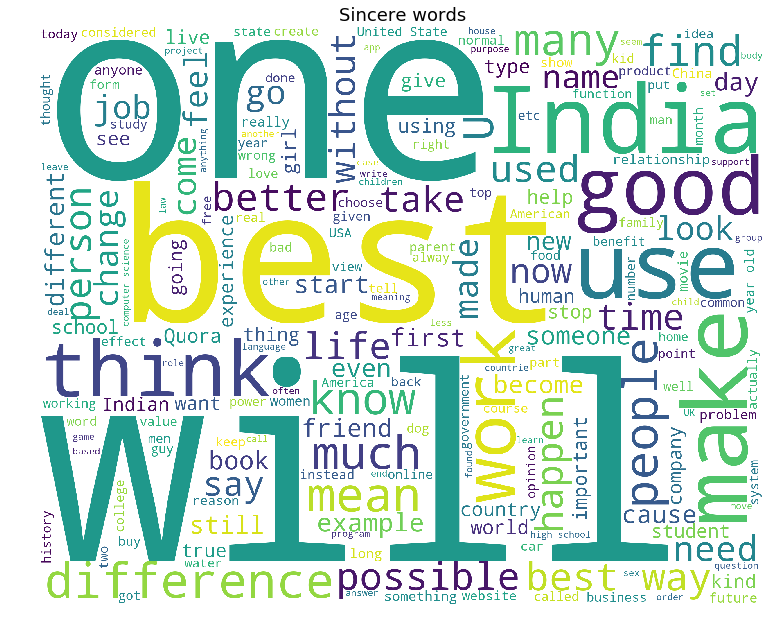

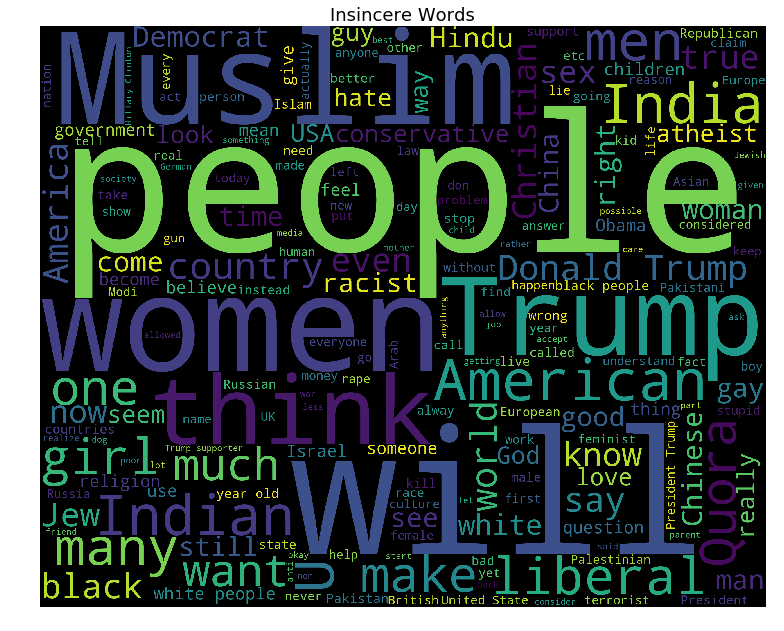

In [28]:
from wordcloud import WordCloud,STOPWORDS

def wordcloud_draw(data, title, color='black'):
    words = ' '.join(data)
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(words)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.title(title, fontdict={'fontsize':18})
    plt.axis('off')
    plt.show()

title = "Sincere words"
wordcloud_draw(train_df[train_df['target']==0]['question_text'], title, 'white')
title = "Insincere Words"
wordcloud_draw(train_df[train_df['target']==1]['question_text'], title, 'black')

# 2. Data Preparation
This section of the notebook is devoted to preprocessing the raw data into a form that the neural network can understand.

In [29]:
# Extract the training data and corresponding labels
text = train_df['question_text'].fillna('unk').values
labels = train_df['target'].values

# Split into training and validation sets by making use of the scikit-learn
# function train_test_split
X_train, X_val, y_train, y_val = train_test_split(text, labels,\
                                                  test_size=0.2)

## 2.1 Create Word Embedding Matrix
The code in this section will identify the most commonly occurring words in the dataset. Then, it will extract the vectors for each one of these words from the GloVe pretrained word embedding and place them in an embedding layer matrix. This embedding layer will serve as the first layer of the neural network. 

Read more about GloVe word embeddings [here](https://nlp.stanford.edu/projects/glove/).

Note that other word embeddings are also available for this competition, however glove was chosen for this notebook. 

In [30]:
embed_size = 300 # Size of each word vector
max_words = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use

In [31]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(list(X_train))

# The tokenizer will assign an integer value to each word in the dictionary
# and then convert each string of words into a list of integer values
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)

word_index = tokenizer.word_index
print('The word index consists of {} unique tokens.'.format(len(word_index)))

## Pad the sentences 
X_train = pad_sequences(X_train, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)

The word index consists of 196358 unique tokens.


In [32]:
# Create the embedding dictionary from the word embedding file
embedding_dict = {}
filename = os.path.join('../input/embeddings/', 'glove.840B.300d/glove.840B.300d.txt')
with open(filename) as f:
    for line in f:
        line = line.split()
        token = line[0]
        try:
            coefs = np.asarray(line[1:], dtype='float32')
            embedding_dict[token] = coefs
        except:
            pass
print('The embedding dictionary has {} items'.format(len(embedding_dict)))

The embedding dictionary has 2195884 items


In [33]:
# Create the embedding layer weight matrix
embed_mat = np.zeros(shape=[max_words, embed_size])
for word, idx in word_index.items():
    # Word index is ordered from most frequent to least frequent
    # Ignore words that occur less frequently
    if idx >= max_words: continue
    vector = embedding_dict.get(word)
    if vector is not None:
        embed_mat[idx] = vector

# 3. Neural Network Training
This network configuration uses the pretrained GloVe embedding layer as the first layer of the network. This is followed by a bidirectional LSTM and then pooling layer. Finally, there are 2 dense layers leading to the final prediction. Feel free to modify network parameters and architecture. This is merely a starting point that provides adequate results. 

In [34]:
def create_lstm():
    input = Input(shape=(maxlen,))
    
    # Embedding layer has fixed weights, so set 'trainable' to False
    x = Embedding(max_words, embed_size, weights=[embed_mat], trainable=False)(input)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(16, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=input, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model

In [35]:
# Create and train network
lstm = create_lstm()
lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=512)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 128)          187392    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total para

# 4. Predictions
The remainder of this notebok will generate predictions from the test set and write them to a submission csv file for the kaggle competition.

In [36]:
test_df = pd.read_csv('../input/test.csv')
X_test = test_df['question_text'].values

# Perform the same preprocessing as was done on the training set
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=maxlen)

# Make predictions, ensure that predictions are in integer form
preds = np.rint(lstm.predict([X_test], batch_size=1024, verbose=1)).astype('int')
test_df['prediction'] = preds

56370/56370 [==============================] - 3s 49us/step


Let's examine a few examples of sincere predictions and insincere predictions. It appears that our network is making meaningful predictions.

In [37]:
n=5
sin_sample = test_df.loc[test_df['prediction'] == 0]['question_text'].head(n)
print('Sincere Samples:')
for idx, row in enumerate(sin_sample):
    print('{}'.format(idx+1), row)

print('\n')
print('Insincere Samples:')
insin_sample = test_df.loc[test_df['prediction'] == 1]['question_text'].head(n)
for idx, row in enumerate(insin_sample):
    print('{}'.format(idx+1), row)

Sincere Samples:
1 My voice range is A2-C5. My chest voice goes up to F4. Included sample in my higher chest range. What is my voice type?
2 How much does a tutor earn in Bangalore?
3 What are the best made pocket knives under $200-300?
4 Why would they add a hypothetical scenario that’s impossible to happen in the link below? It shows what 800 meters rise in sea level would look like.
5 What is the dresscode for Techmahindra freshers?


Insincere Samples:
1 Why don't India start a War with Pakistan ? They Kill our Soldiers.
2 Why do people think white privilege is real when it's blatantly not?
3 Why does Quora send me a notice because I told a guy from England that he wasn’t American so he shouldn’t worry about our gun laws?
4 Can a bleeding heart liberal be happily married to a militant Republican, when they fundamentally disagree on everything? I'm an optimistic feminist who believes in hope, and he's a die hard gun enthusiast who borders on misogyny and racism.
5 Why do these Sikhs

In [ ]:
test_df = test_df.drop('question_text', axis=1)
test_df.to_csv('submission.csv', index=False)